In [49]:
import torch
import tqdm
import math
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from utils import variance_norms, isometry_gap


# Define the MLP model with layer normalization
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, normalize='LN'):
        super(MLP, self).__init__()
        if normalize=='LN':
            self.norm = nn.LayerNorm(hidden_size)
        elif normalize=='None':
            self.norm = nn.Identity()
            
        self.layers = nn.Sequential()
        self.layers.add_module('layer0', nn.Linear(input_size, hidden_size))
        self.layers.add_module('norm0', self.norm)

        for i in range(1, num_layers - 1):
            self.layers.add_module(f'act{i}', nn.ReLU())
            self.layers.add_module(f'norm{i}', self.norm)
            self.layers.add_module(f'layer{i}', nn.Linear(hidden_size, hidden_size))

        self.layers.add_module(f'layer{num_layers-1}', nn.Linear(hidden_size, num_classes))
        self.apply(self.init_weights)

    def init_weights(self, layer):
        if isinstance(layer, nn.Linear):
            std = 1 / math.sqrt(layer.weight.size(1))
            nn.init.normal_(layer.weight, mean=0, std=std)
            
    def forward(self, x):
        x = x.view(x.size(0), -1)
        hidden_layers = []
        for i, layer in enumerate(self.layers):
            x = layer(x)
            hidden_layers.append((layer,x))
        output = x
        return output, hidden_layers

# Hyperparameters
input_size = 3 * 32 * 32
hidden_size = 1000
num_layers = 30
num_classes = 10
batch_size = 256
learning_rate = 0.001
num_epochs = 3
num_rerun = 5


# Data preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Create the model, loss function, and optimizer
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')


df = []
for rerun in range(num_rerun):
    for normalize in ["LN"]:

        model = MLP(input_size, hidden_size, num_layers, num_classes,normalize=normalize).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        for epoch in tqdm.trange(num_epochs):
            for i, (images, labels) in enumerate(train_loader):
                if epoch==0:
                    break
                images = images.to(device)
                labels = labels.to(device)

                outputs, hidden = model(images)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            if epoch>0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

            # Test the model
            model.eval()
            with torch.no_grad():
                correct = 0
                total = 0
                for i, (images, labels) in enumerate(test_loader):
                    images = images.to(device)
                    labels = labels.to(device)

                    outputs, hidden = model(images)
                    loss = criterion(outputs, labels)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    for li,(l,h) in enumerate(hidden):
                        ig = isometry_gap(h.flatten(1) @ h.flatten(1).t(),epsilon=1e-8).item()
                        nb = variance_norms(h.flatten(1)).item()
                        df.append({'rerun': rerun,
                                   'normalize': normalize,
                                   'l': li, 'layer': type(l).__name__, 
                                   'iso_gap': ig, 
                                   'norm_bias': nb, 
                                   'stage': 'test', 
                                   'loss': loss.item(),
                                   'accuracy': (predicted == labels).sum().item() / len(labels),
                                   'epoch': epoch, 
                                   'i': i})

            print(f'Accuracy of the model on the 10000 test images: {100 * correct / total:.2f}%')
df = pd.DataFrame(df)

Files already downloaded and verified
Files already downloaded and verified


 33%|███▎      | 1/3 [00:18<00:37, 18.51s/it]

Accuracy of the model on the 10000 test images: 9.68%
Epoch [2/3], Loss: 2.4419


 67%|██████▋   | 2/3 [00:42<00:21, 21.68s/it]

Accuracy of the model on the 10000 test images: 10.18%
Epoch [3/3], Loss: 2.3210


100%|██████████| 3/3 [01:06<00:00, 22.23s/it]

Accuracy of the model on the 10000 test images: 12.34%



 33%|███▎      | 1/3 [00:18<00:37, 18.51s/it]

Accuracy of the model on the 10000 test images: 9.76%
Epoch [2/3], Loss: 2.1653


 67%|██████▋   | 2/3 [00:45<00:23, 23.51s/it]

Accuracy of the model on the 10000 test images: 18.22%
Epoch [3/3], Loss: 2.0395


100%|██████████| 3/3 [01:12<00:00, 24.09s/it]

Accuracy of the model on the 10000 test images: 21.01%



 33%|███▎      | 1/3 [00:18<00:37, 18.56s/it]

Accuracy of the model on the 10000 test images: 10.71%
Epoch [2/3], Loss: 2.4179


 67%|██████▋   | 2/3 [00:42<00:21, 21.54s/it]

Accuracy of the model on the 10000 test images: 11.11%
Epoch [3/3], Loss: 2.1982


100%|██████████| 3/3 [01:06<00:00, 22.28s/it]

Accuracy of the model on the 10000 test images: 13.19%



 33%|███▎      | 1/3 [00:18<00:37, 18.55s/it]

Accuracy of the model on the 10000 test images: 9.67%
Epoch [2/3], Loss: 2.1249


 67%|██████▋   | 2/3 [00:48<00:24, 24.97s/it]

Accuracy of the model on the 10000 test images: 20.92%
Epoch [3/3], Loss: 1.9653


100%|██████████| 3/3 [01:17<00:00, 25.81s/it]

Accuracy of the model on the 10000 test images: 23.94%



 33%|███▎      | 1/3 [00:18<00:37, 18.55s/it]

Accuracy of the model on the 10000 test images: 9.74%
Epoch [2/3], Loss: 2.2725


 67%|██████▋   | 2/3 [00:44<00:22, 22.74s/it]

Accuracy of the model on the 10000 test images: 15.80%
Epoch [3/3], Loss: 2.1199


100%|██████████| 3/3 [01:10<00:00, 23.36s/it]

Accuracy of the model on the 10000 test images: 18.72%


<ipython-input-52-1217cf3d7532>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.l = df2.l//3


<Figure size 640x480 with 0 Axes>

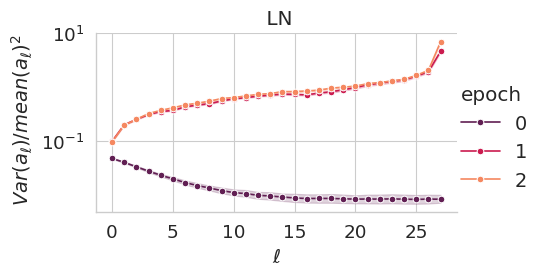

In [52]:
def plot_line_graph(data, y, y_label, file_name, **kwargs):
    plt.figure()
    sns.set_style('whitegrid')
    sns.set_context('paper', font_scale=1.5)  # Increase the font size
    g = sns.FacetGrid(data=data, height=3, aspect=1.5, **kwargs)
    g.map(sns.lineplot, "l", y, marker="o",)
    g.set_ylabels(y_label, fontsize=14)  # Increase the font size for y-label
    g.set_xlabels("$\ell$", fontsize=14)  # Increase the font size for x-label
    if 'col' in kwargs:
        g.set_titles(" {col_name}", fontsize=14)  # Increase the font size for titles
    if 'hue' in kwargs:
        ncols = len(df[kwargs['hue']].unique())
        g.add_legend(alignment='left', fontsize=14)  # Increase the font size for legend
        # sns.move_legend(g, "lower center", bbox_to_anchor=(.45, -0.05), ncols=ncols, frameon=False)
    plt.yscale('log')
    plt.savefig(file_name, bbox_inches="tight")
    plt.show()

df2 = df.loc[(df.layer=='ReLU')&(df.epoch<10)]
df2.l = df2.l//3
plot_line_graph(data=df2,#.loc[df.norm_layer=='BN'], 
                y='norm_bias', y_label=" $Var(a_\ell)/mean(a_\ell)^2$", 
                hue="epoch",col="normalize", 
                palette="rocket",
                file_name='plots/norm_bias_training.pdf')

<ipython-input-53-35dd3113c015>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.l = df2.l//3


<Figure size 640x480 with 0 Axes>

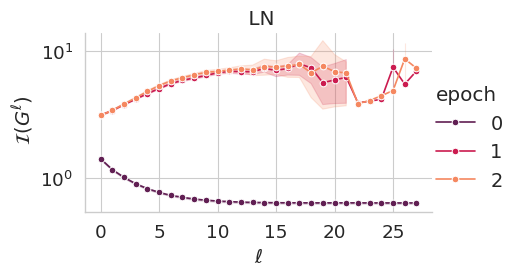

In [53]:

df2 = df.loc[(df.layer=='ReLU')]
df2.l = df2.l//3
plot_line_graph(data=df2,#.loc[df.norm_layer=='BN'], 
                y='iso_gap', y_label=" $\mathcal{I}(G^\ell)$", 
                hue="epoch",col="normalize", 
                palette="rocket",
                file_name='plots/iso_gap_training.pdf')